# Time Series Clustering

## What is clustering?

## What are time series?

## Analysis

In [1]:
# Native Libraries
import os
import math
from collections import Counter

# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [5]:
os.getcwd()

'/Users/cindyzhang/ml-concepts/timeseries'

In [8]:
directory = './data/'

In [9]:
mySeries = []
namesSeries = []

for fn in os.listdir(directory):
    if fn.endswith(".csv"):
        df = pd.read_csv(directory + fn)
        # only need these columns
        df = df.loc[:, ["date", "value"]]
        # set data column as index
        df.set_index("date", inplace=True)
        # order data by date
        df.sort_index(inplace=True)
        mySeries.append(df)
        namesSeries.append(fn[:-4])
        

Number of Series

In [10]:
len(mySeries)

23

For 23 series, create 6 x 4 grid with 24 slots to hold plots

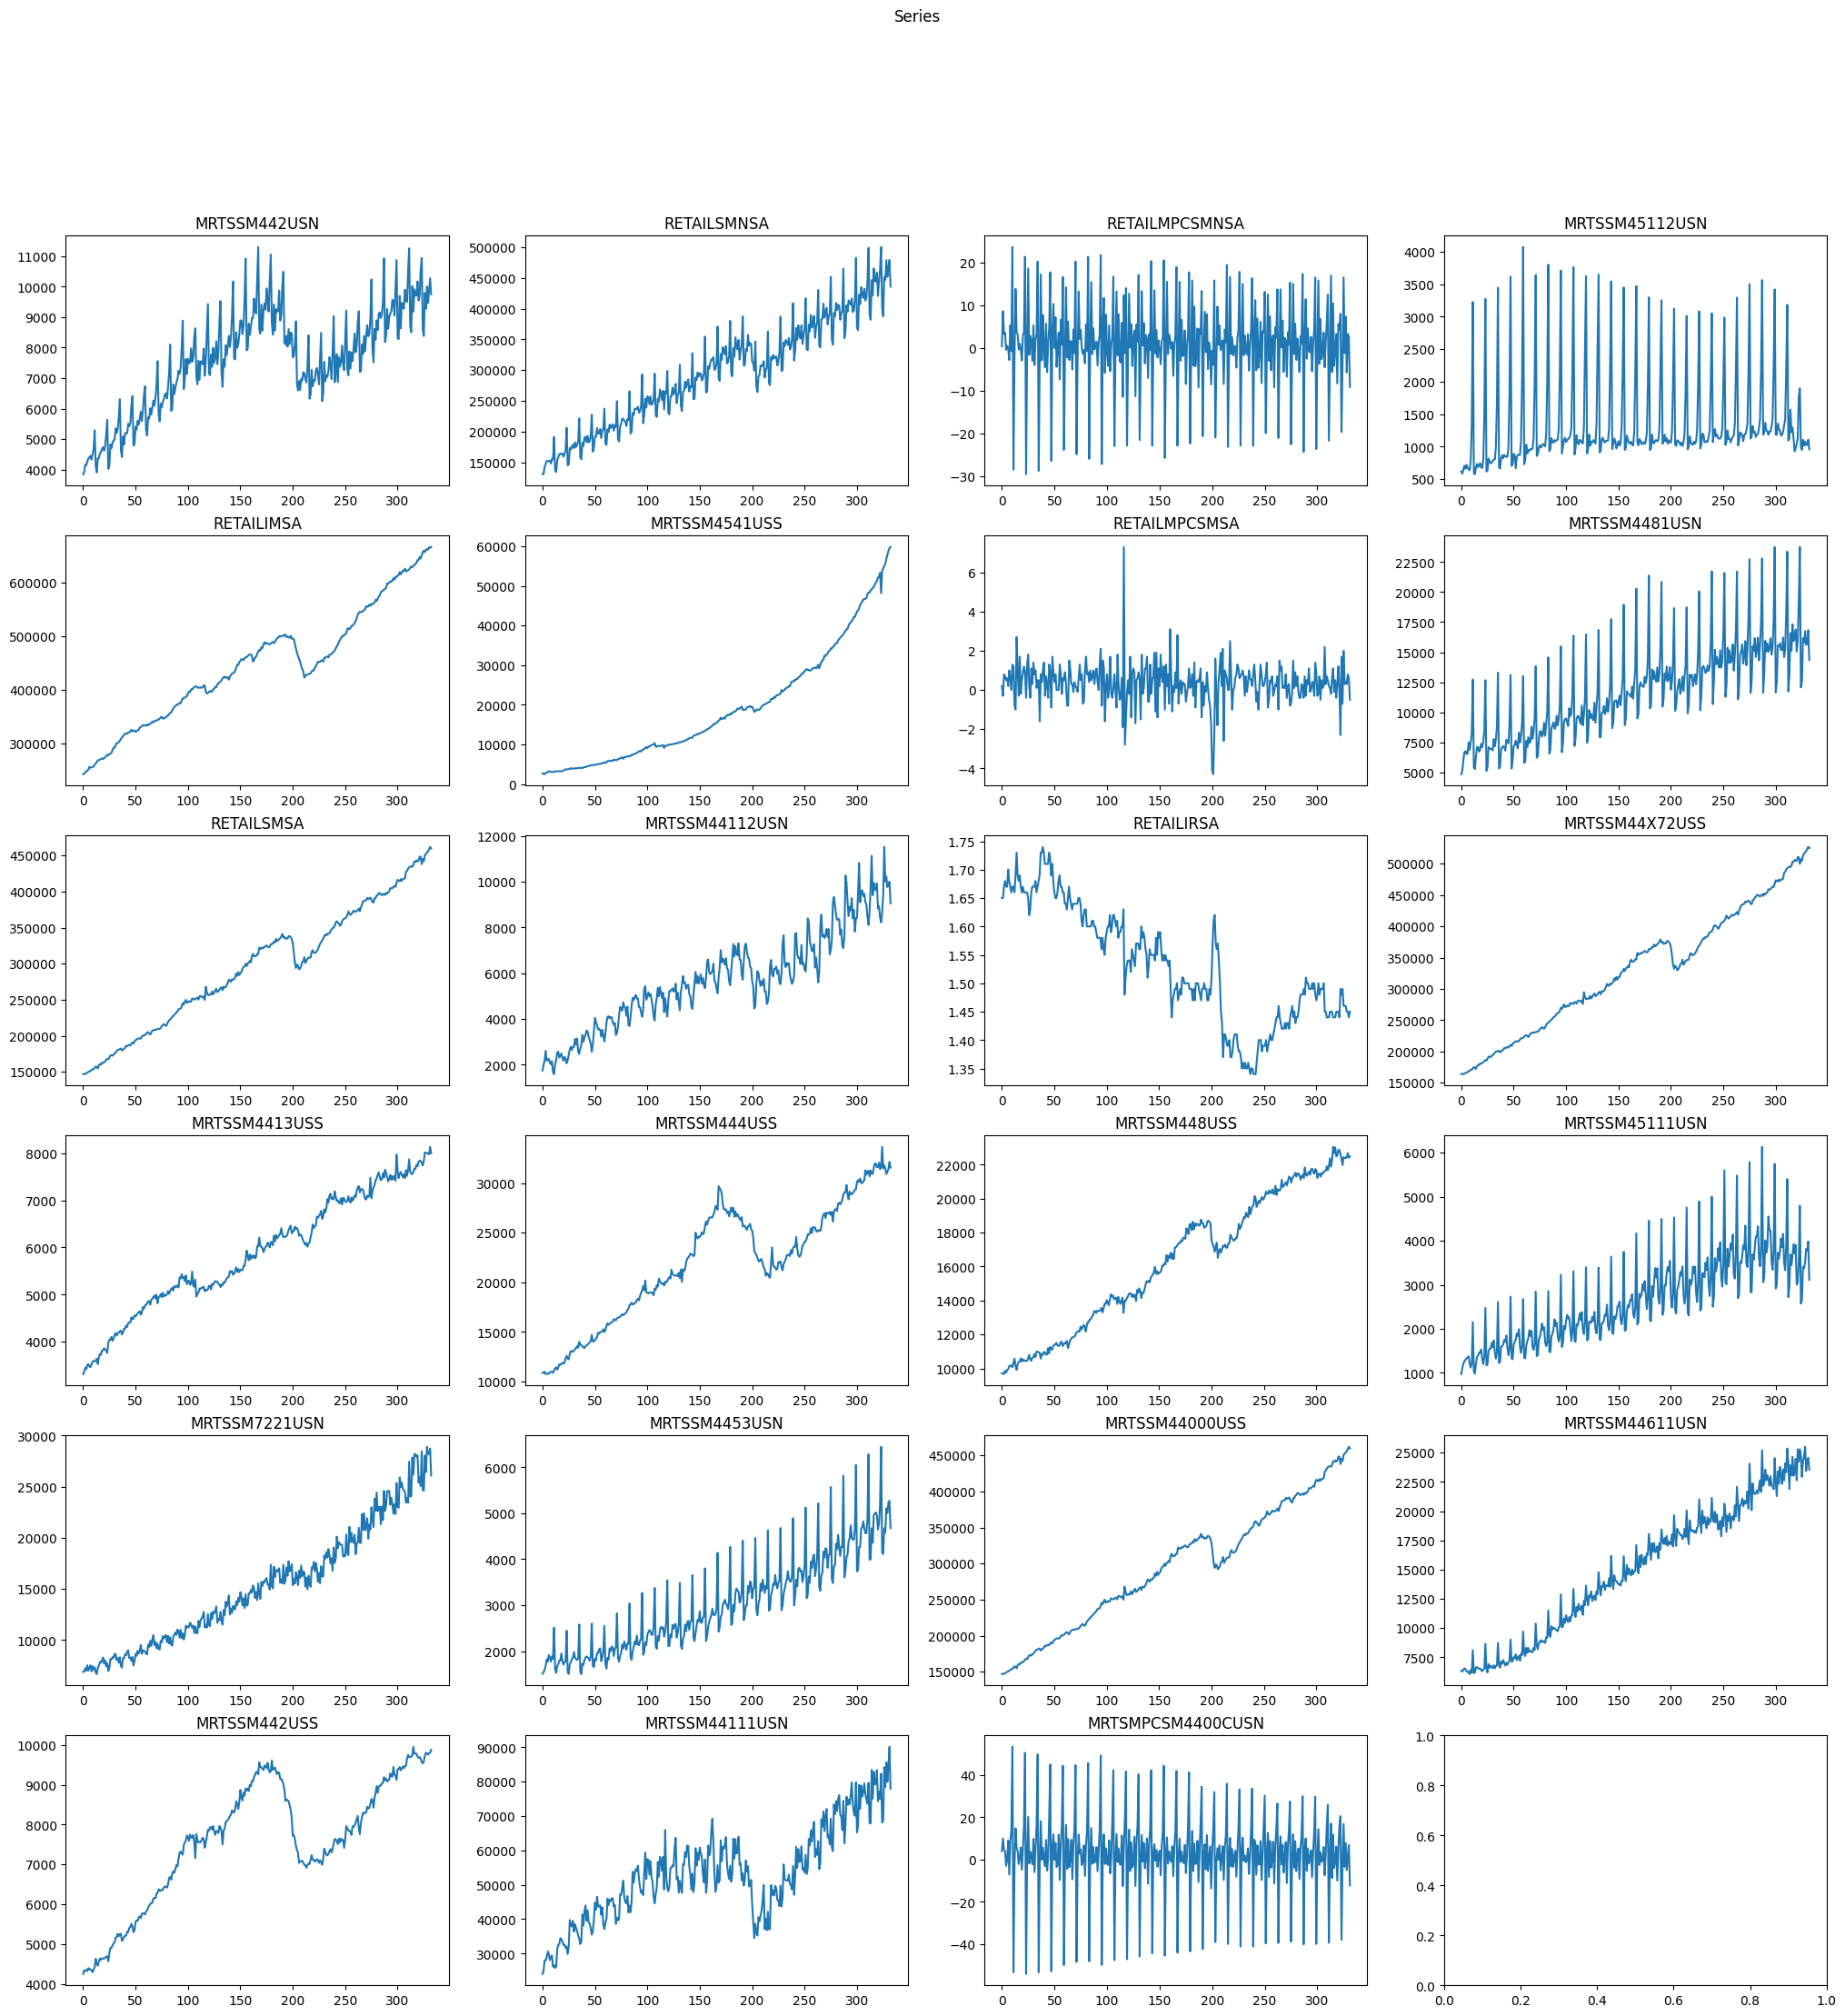

In [11]:
fig, axs = plt.subplots(6, 4, figsize=(25, 25))
fig.suptitle('Series')

for i in range(6):
    for j in range(4):
        if i*4 + j+1 > len(mySeries):
            continue
        axs[i, j].plot(mySeries[i*4 + j].values)
        axs[i, j].set_title(namesSeries[i*4 + j])

plt.show()

It seems like there are pretty much similar time series such as `MRTSSM44000USS` and `RETAILMSA` or `MRTSSM7221USN` and `MRTSSM44611USN`

## Data Preprocessing

Series lengths

In [12]:
lengths = {len(series) for series in mySeries}
lengths

{332, 333}

Find series with maximum length

In [13]:
max_len = max(lengths)
longest_series = None
for series in mySeries:
    if len(series) == max_len:
        longest_series = series
        break

Re-index series according to the one with the maximum length and fill empty dates with `np.nan`

In [14]:
problemSeries = []
for i in range(len(mySeries)):
    if len(mySeries[i])!= max_len:
        problemSeries.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)
problemSeries

[2, 6, 22]

Use linear interpolation to fill the gap since series are only missing one point \
For more missingness, can use complex interpolation such as quadratic, spline, barycentric

In [15]:
for i in problemSeries:
    mySeries[i].interpolate(limit_direction="both",inplace=True)

Check missingness of all series

In [16]:
flag = False
for series in mySeries:
    if series.isnull().values.any():
        flag = True 
        break
flag

False

Normalize data \
Standardization scales data by the minimum and maximum and is better for Gaussian distributed data, whereas normalization scales uses the mean and std and is less affected by outliers

![alt text](https://www.simplilearn.com/ice9/free_resources_article_thumb/Normalization_vs_Standardization.jpg)

Source: https://www.simplilearn.com/normalization-vs-standardization-article

Standardization is appropriate here, since the series seem normally distributed. Note that we scale each series by their own values and not the others

In [17]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

Check the results

In [18]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])

max: 1.0	min: 0.0
[0.         0.00832103 0.04173936 0.039592   0.05757616]


## Clustering

# Self Organizing Maps (SOM)
SOM are a type of neural network that is trained using unsupervised learning to produce a low-dimensional representation of the input space of the training samples \
SOM differ from other articical neural networks since they apply competitive/cooperative learning as opposed to error-correction such as in back propagation. This is achieved by using a neighborhood function to preserve the topological propoerties of the input space \
Each node (or multiple of nodes) represents a cluster. We can find which series belows to which cluster by checking the winner node of each series

![test](https://algotech.netlify.com/img/2019/04/Algotech_Post_Self_Organizing_Map.png)

source: https://algotech.netlify.app/blog/self-organizing-maps/

Because the ability to produce a mapping, SOM is a dimensionality reduction method that we can _apply_ to clustering. We achieve this by removing time indices and accept measured values of each date as different features and therefore dimensions of a single data point

For SOM algorithm implementation, we use [minisom](https://github.com/JustGlowing/minisom) and set the following params:
- map size: square root of number of series
- sigma: 0.3
- lr: 0.5
- random weight initilization
- 50,000 iteration

In [19]:
# Set square map with row and col
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(mySeries)
som.train(mySeries, 50000)

In [20]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map, method):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                if method == "SOM":
                    axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
                elif method == "DBA":
                    axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

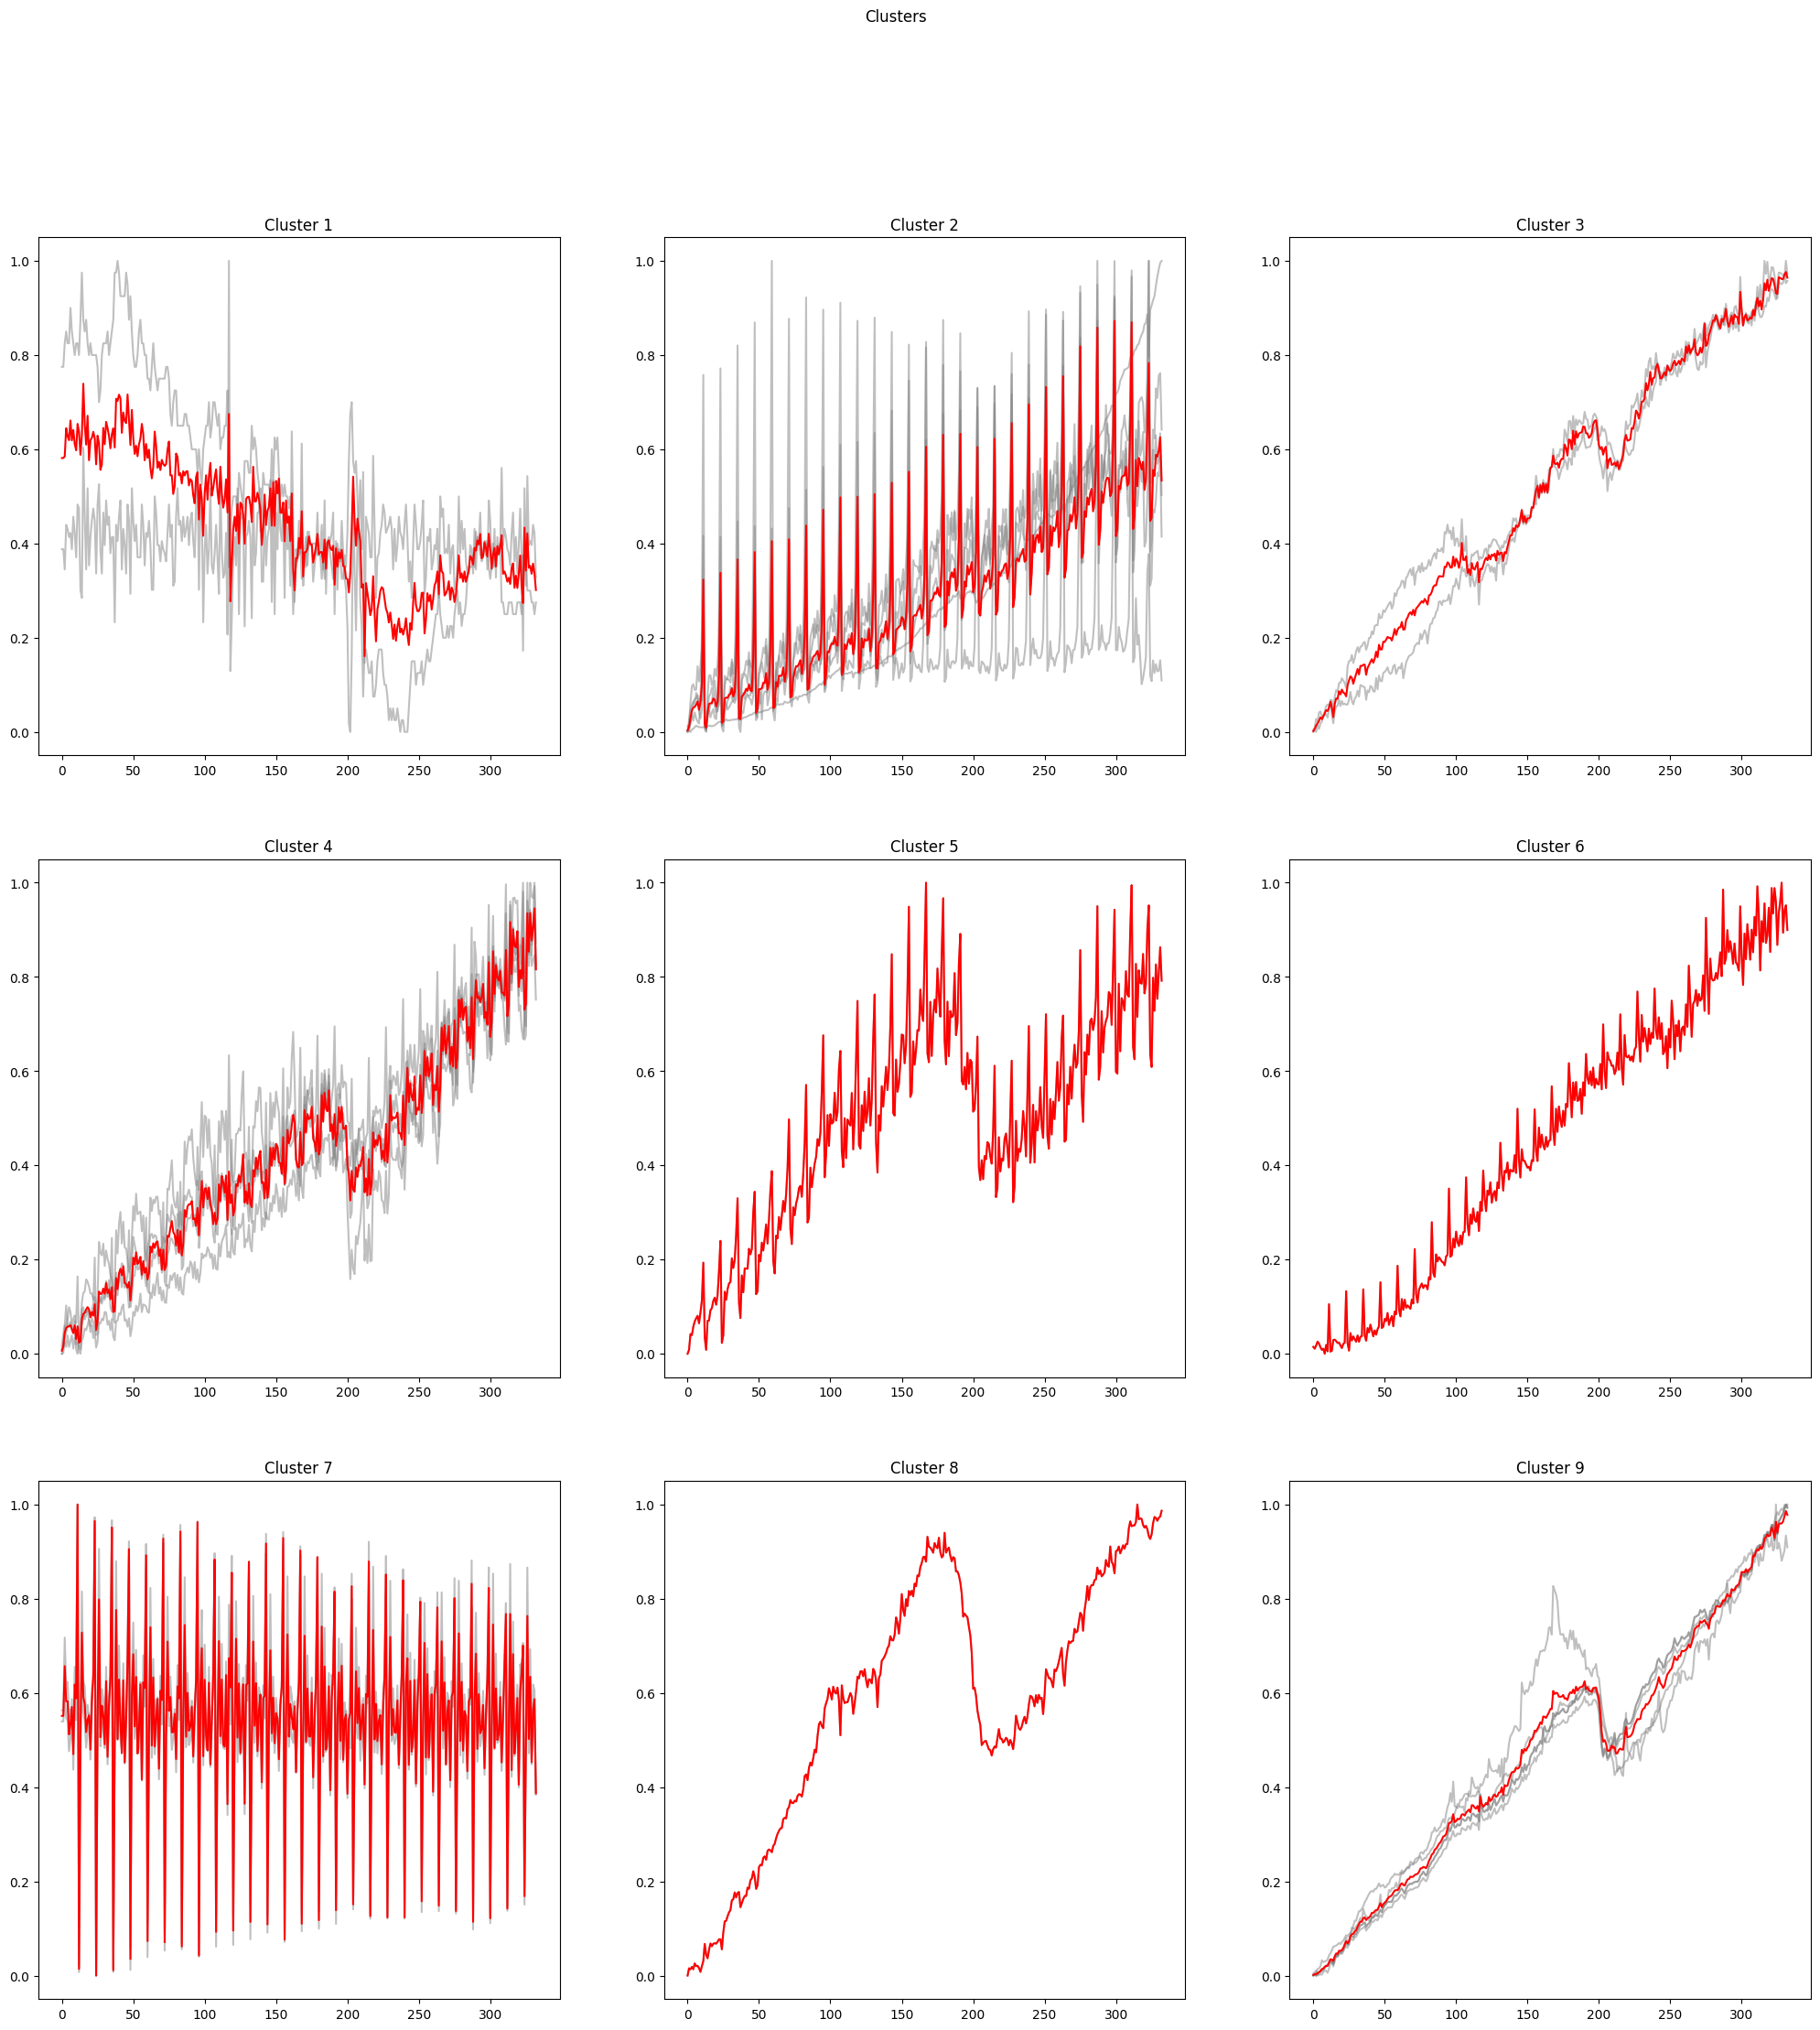

In [21]:
win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map, "SOM")

SOM perfectly clustered the 23 different series into 8 clusters!

## Dynamic Time Warping Barycenter Averaging (DBA)

DBA is another method to extract movement/shape of cluster instead of averaging each series in the cluster

![Arithmetic mean](https://raw.githubusercontent.com/fpetitjean/DBA/master/images/arithmetic.png)


![Arithmetic mean](https://raw.githubusercontent.com/fpetitjean/DBA/master/images/DBA.png)

Source: https://github.com/fpetitjean/DBA/blob/master/README.md

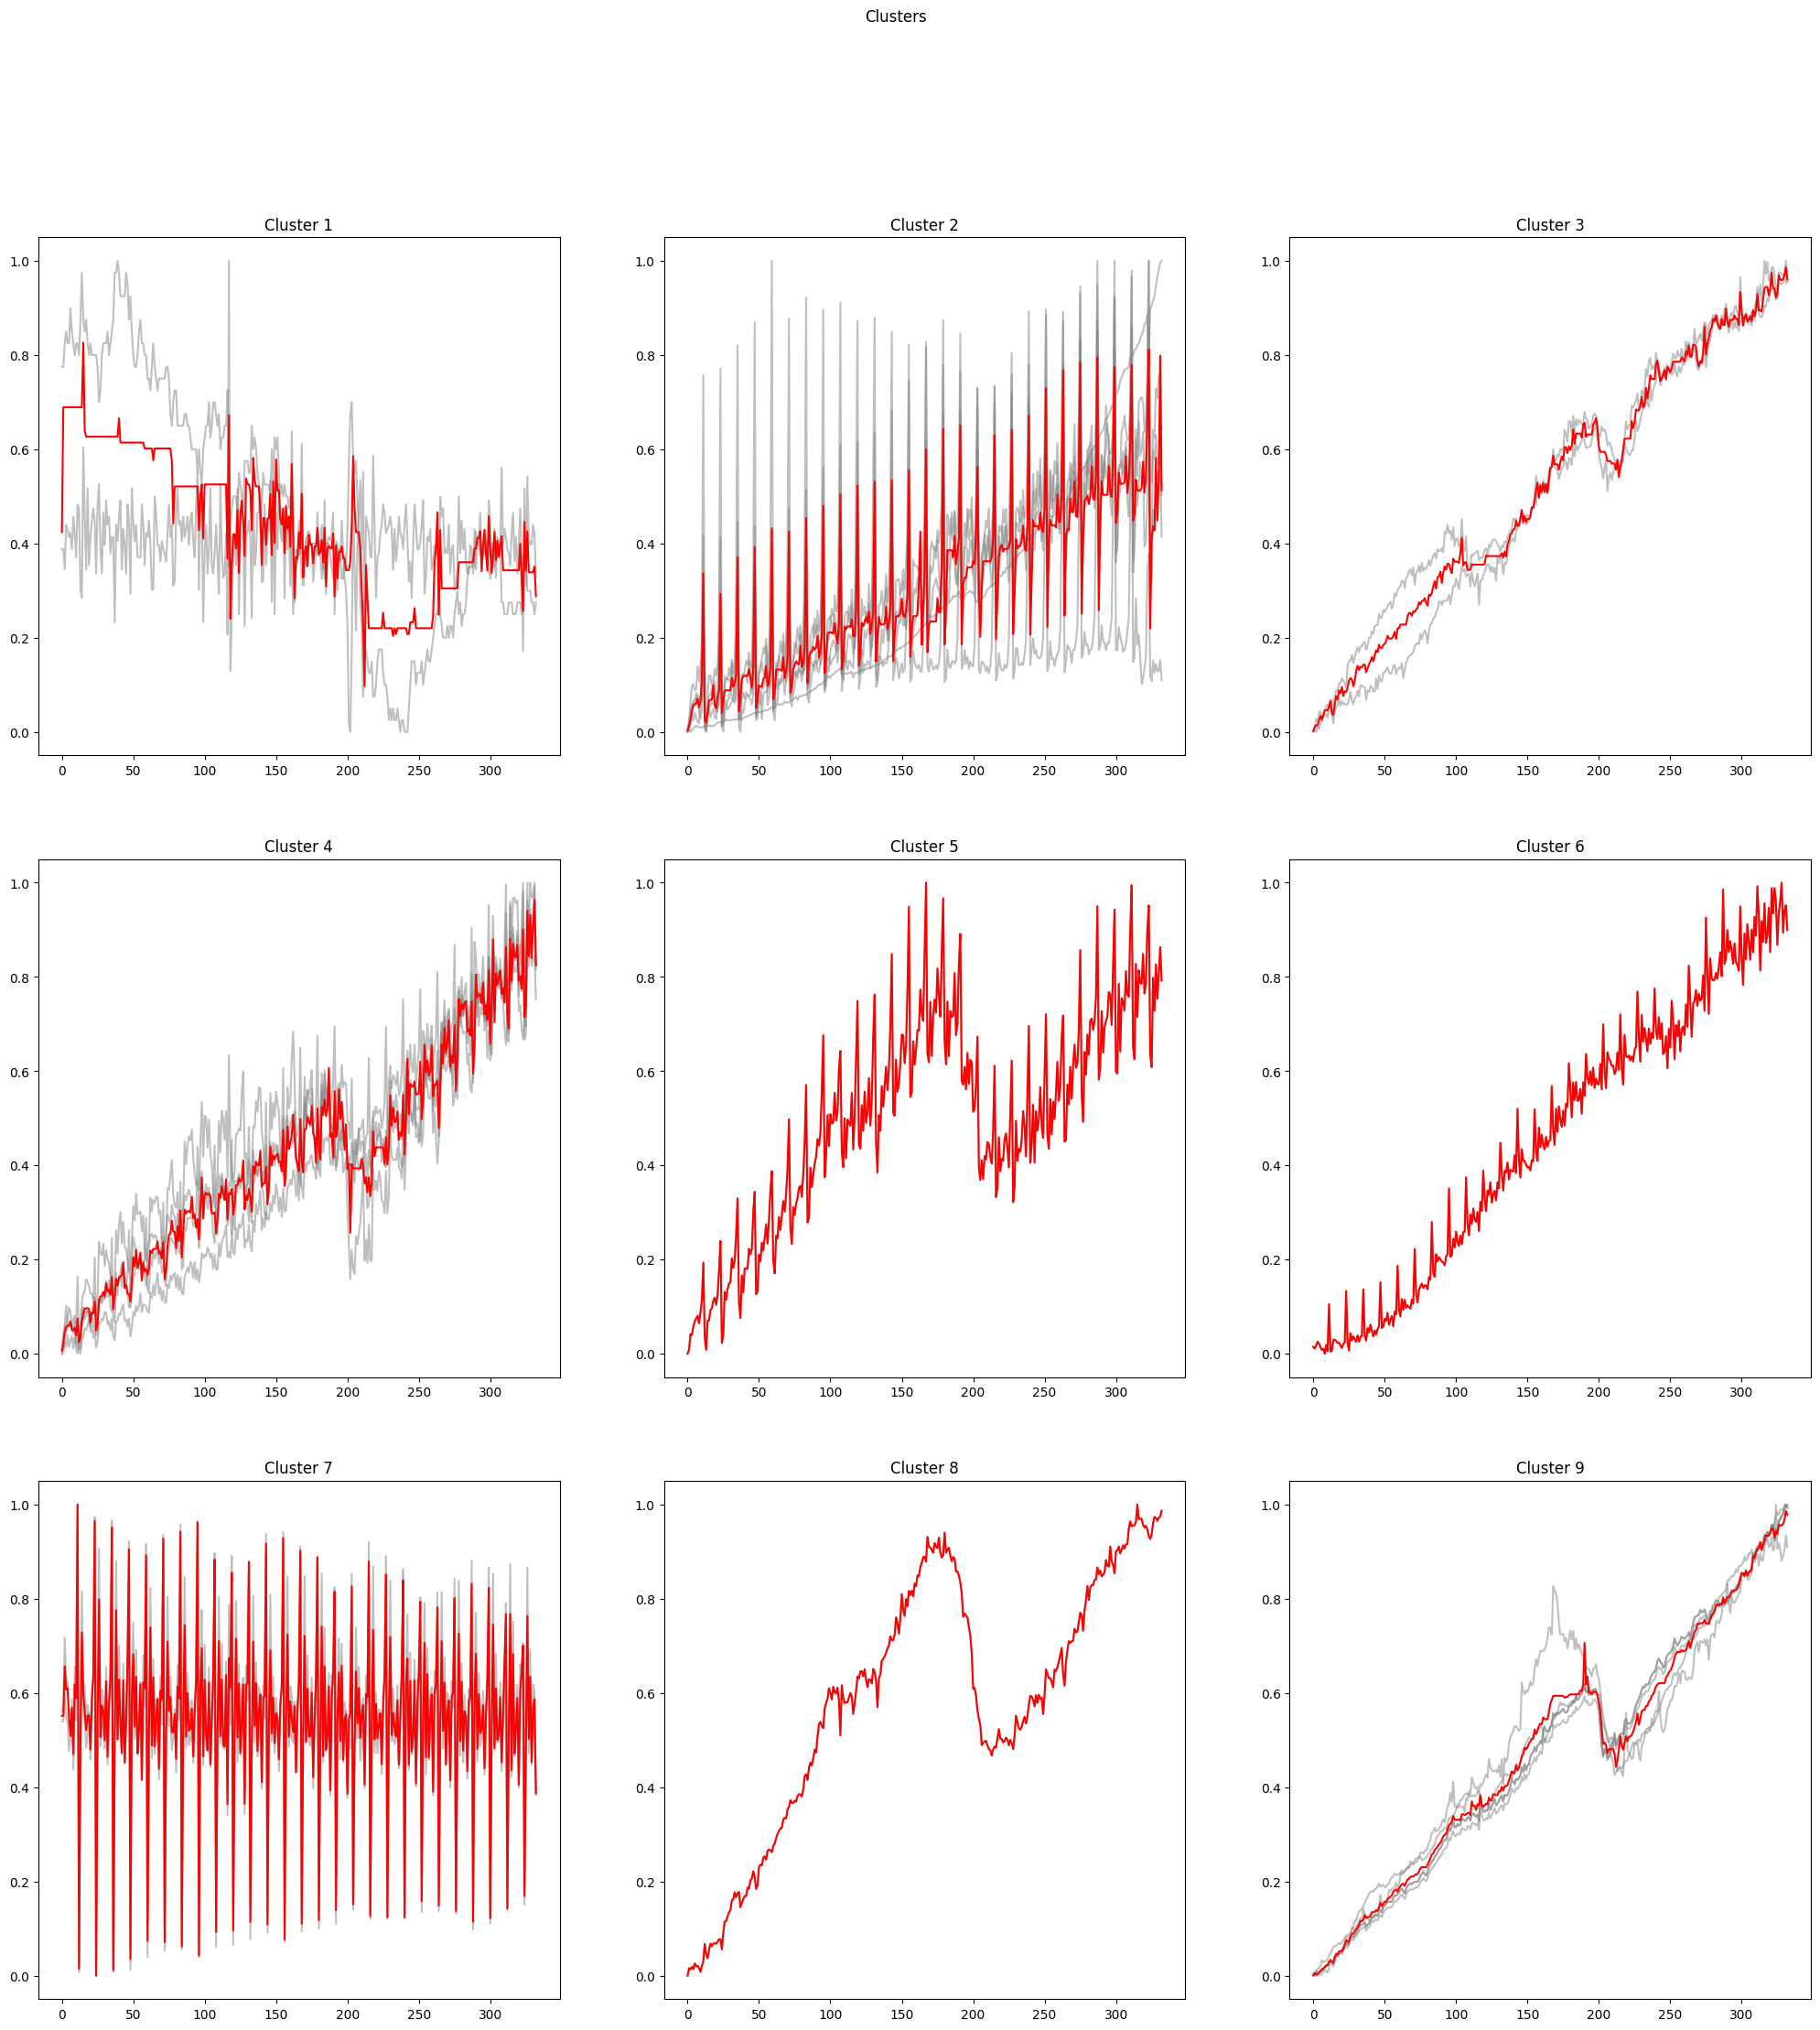

In [22]:
plot_som_series_averaged_center(som_x, som_y, win_map, "DBA")

We can't see much difference from this result but, I highly recommend that to use this method for this purpose. But, also, note that the operation of dba is not a light one. So, if you seek speed, this method might not be for you.

## Cluster Distribution

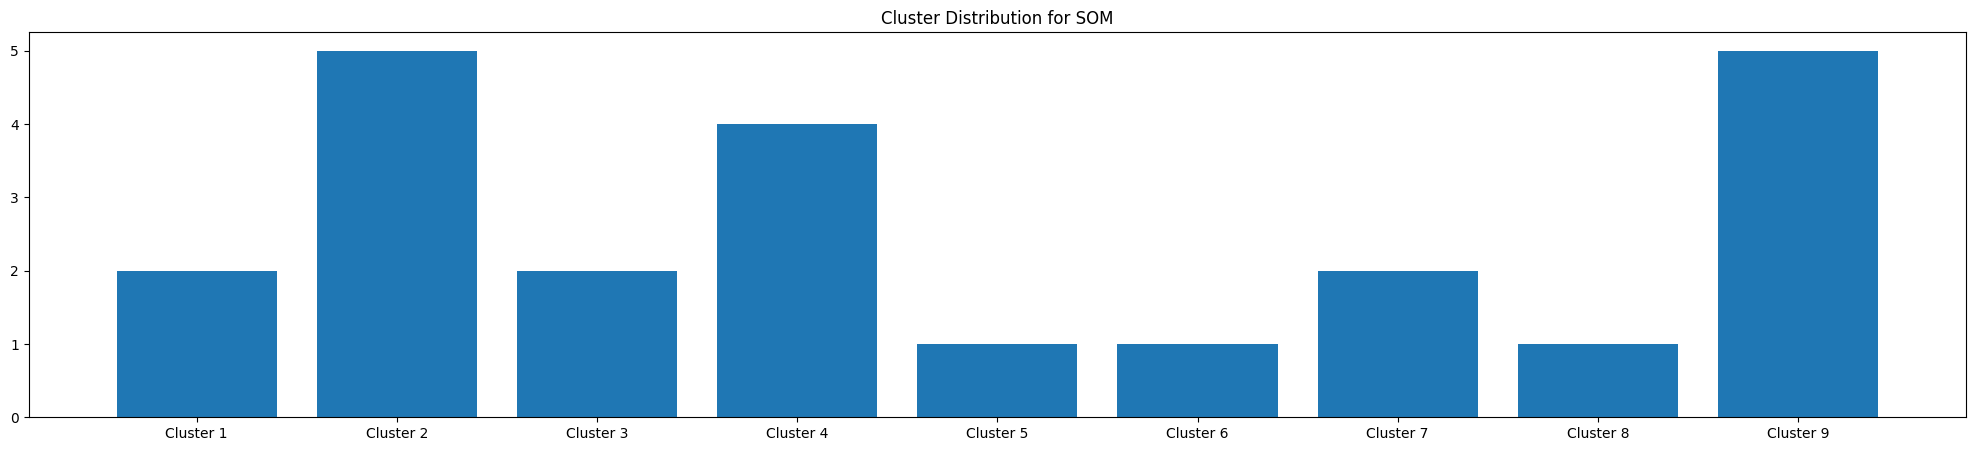

In [28]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

## Assign Series to cluster 

In [30]:
cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesSeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

,Cluster
Series,
RETAILMPCSMSA,Cluster 1
RETAILIRSA,Cluster 1
MRTSSM45112USN,Cluster 2
MRTSSM4453USN,Cluster 2
MRTSSM4541USS,Cluster 2
MRTSSM4481USN,Cluster 2
MRTSSM45111USN,Cluster 2
MRTSSM4413USS,Cluster 3
MRTSSM448USS,Cluster 3


## K-Means
K-means clusters n inputs to k clusters where each data point belongs to a cluster with the nearest mean (cluster centroid). We can visual this using Voronoi cells. It is one of the most populat yet basic algorithms! \
For the distance metric, euclidean distance is typically used. We say in DBA, it is not effective in our case. So we use Dynamic Time Warping (DTW) 
![DTW](https://www.databricks.com/wp-content/uploads/2019/04/Euclidean_vs_DTW.jpg)

In [31]:
# k = square root of the number of points in the training data set in kNN
k = math.ceil(math.sqrt(len(mySeries))) 
km = TimeSeriesKMeans(n_clusters=k, metric="dtw")

labels = km.fit_predict(mySeries)

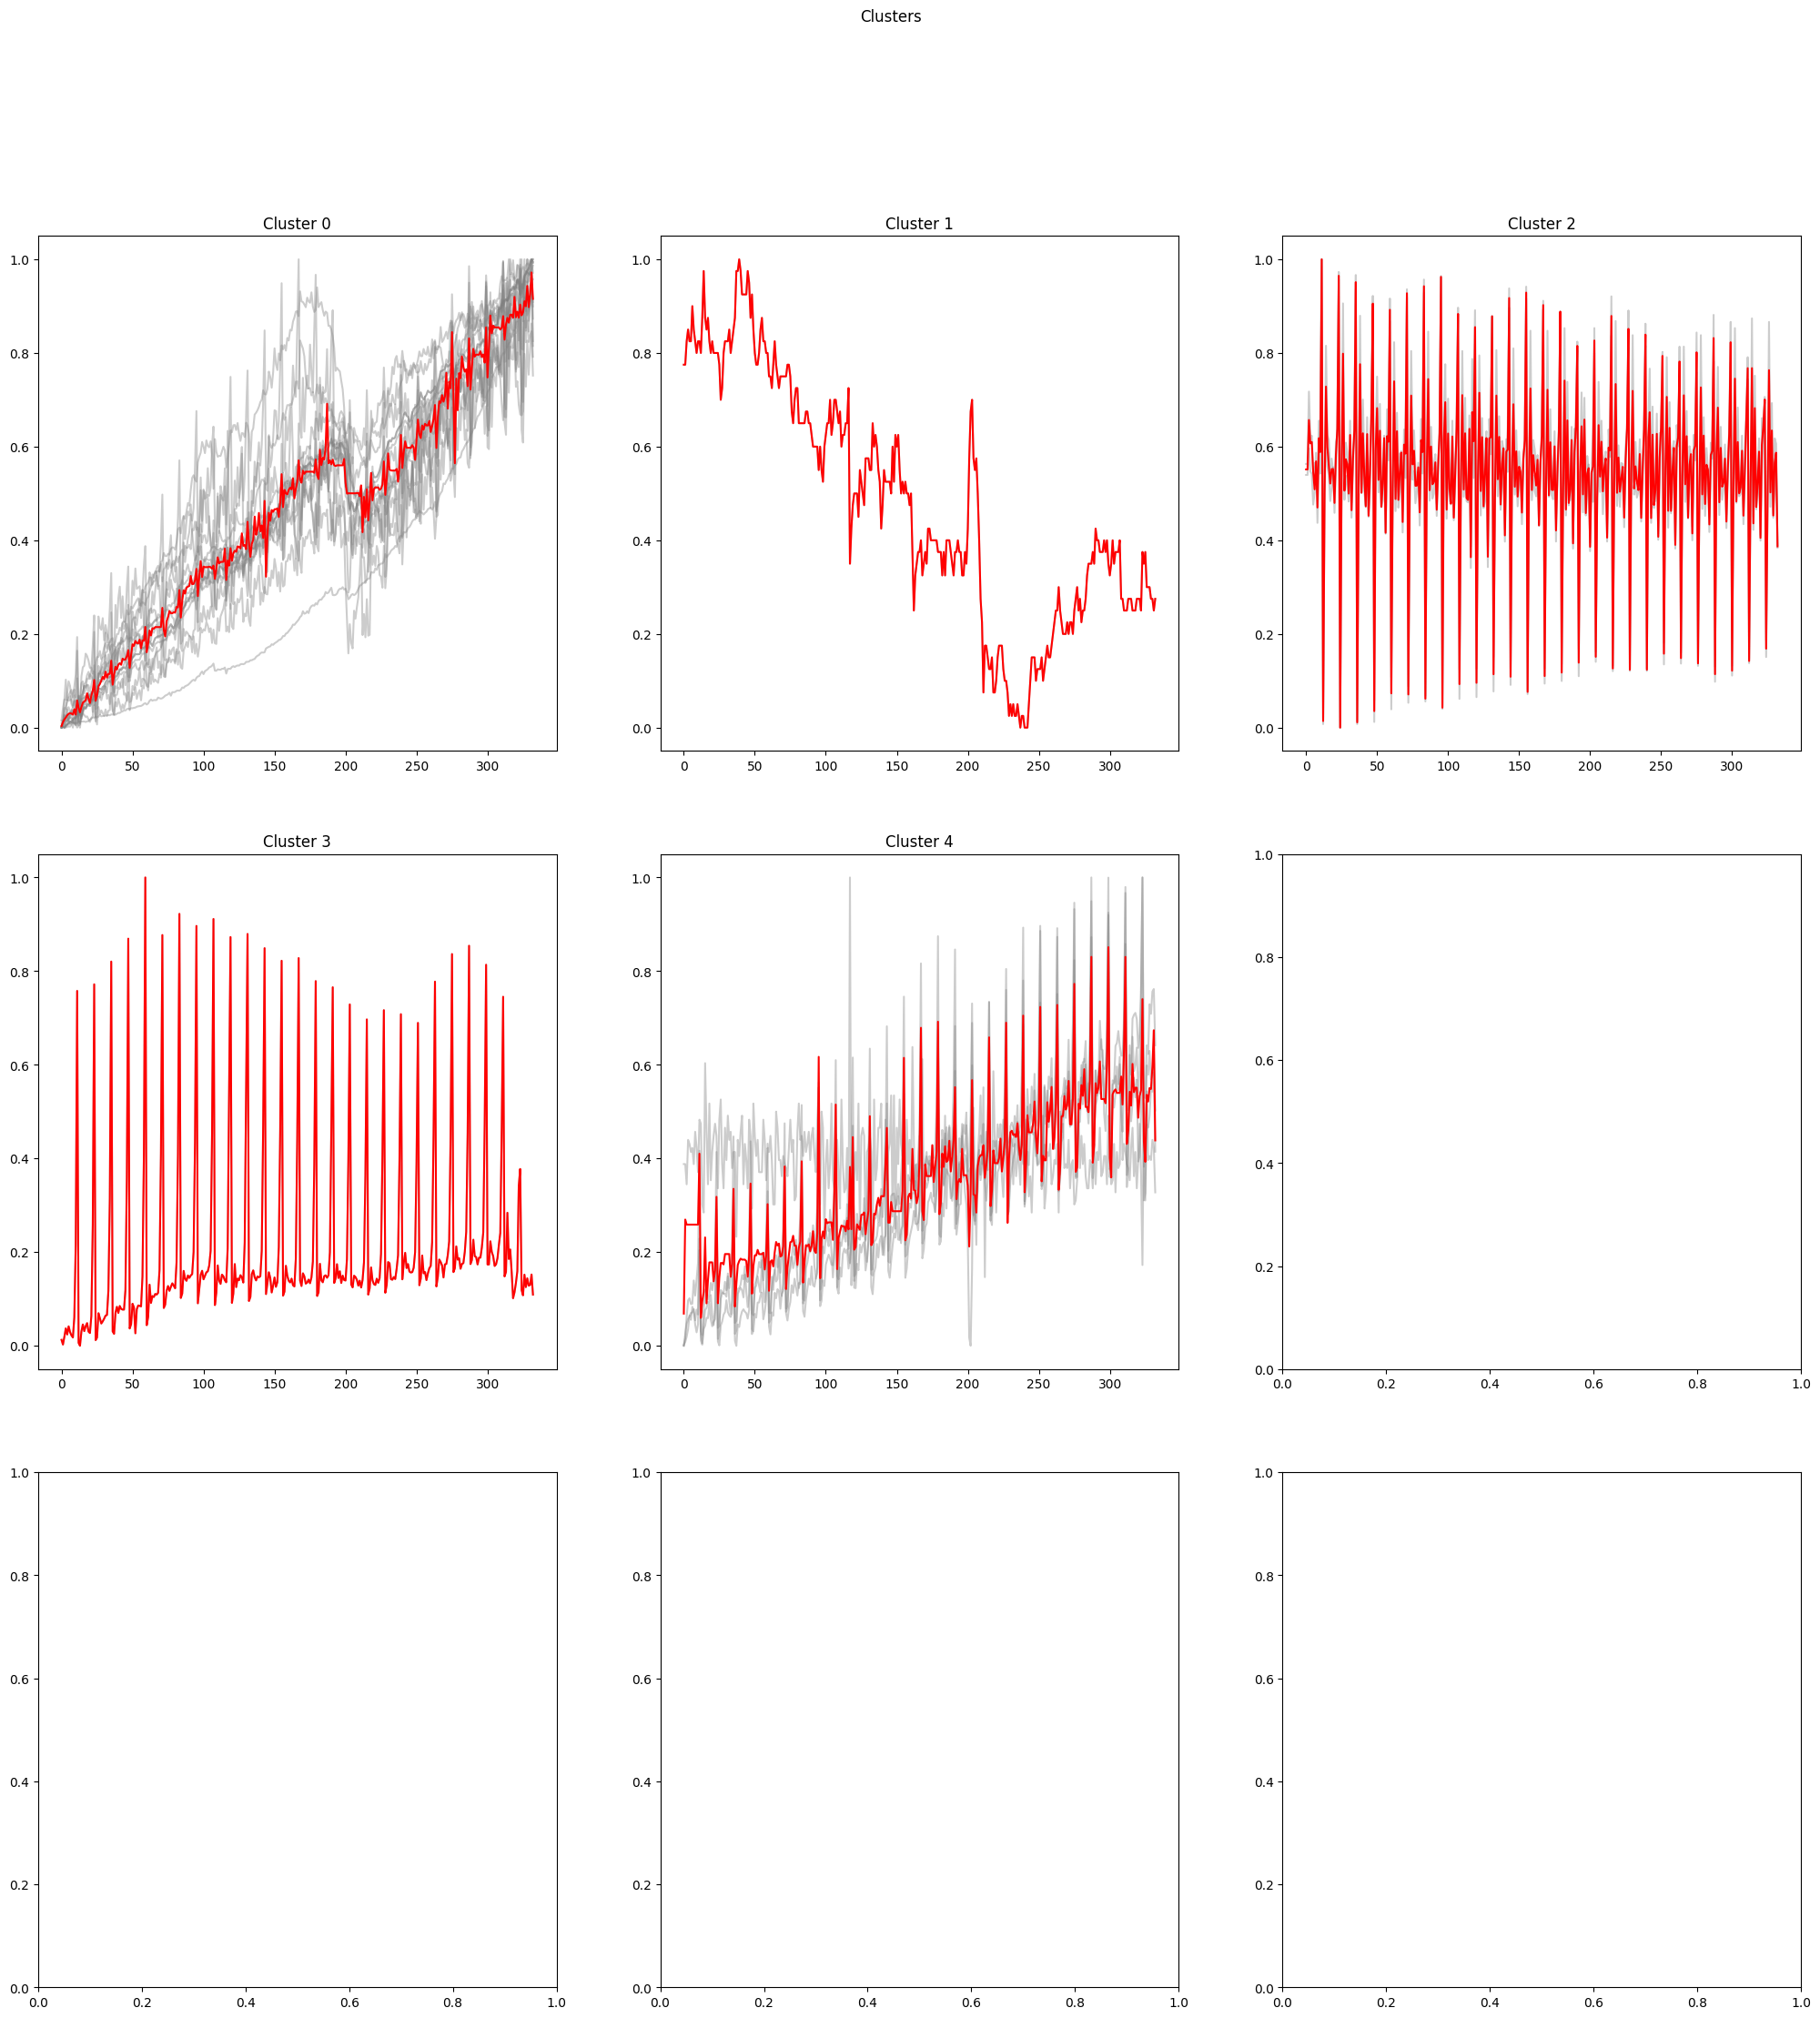

In [34]:
plot_count = math.ceil(math.sqrt(k))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        # axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

k-means clustered the 23 different series into 5 clusters. 2 of the clusters contains only 1 time series which may be deemed as an outlier.

## Cluster Distribution

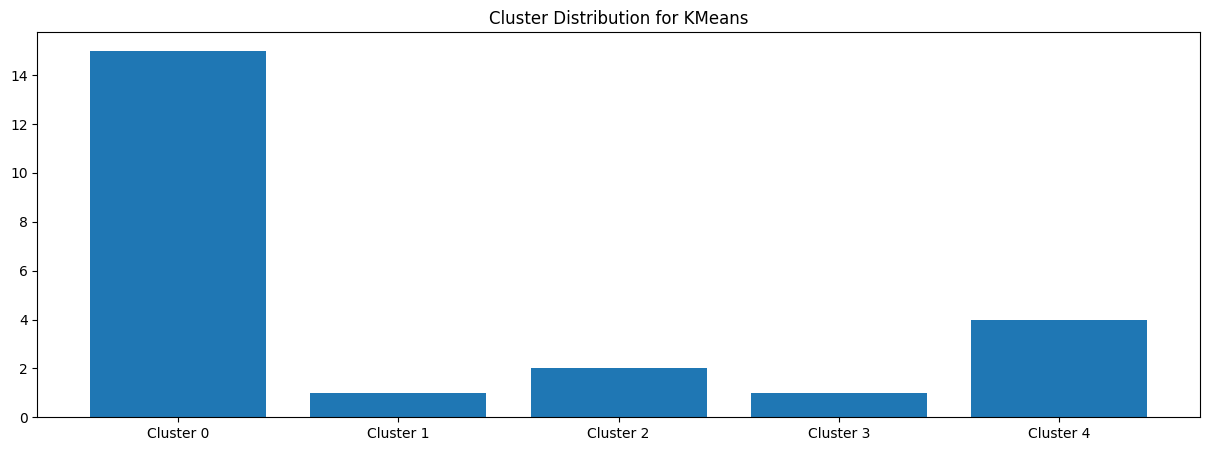

In [37]:
cluster_c = [len(labels[labels==i]) for i in range(k)]
cluster_n = ["Cluster "+str(i) for i in range(k)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

Plotting the distribution of the time series in clusters, k-means clustered 15 of the time series as cluster 1, which is a bit skewed, likely because of `The Curse of Dimentionality` 

## Curse of Dimensionality
A term invented when considering dynamic programming problems, this means that the number of samples needed to estimate a function with a given level of accuracy grows _exponentially_ with respect to the number of input variables (dimensionality) of the function. \
To solve this problem there are numerous algorithms that can be helpful such as PCA which is the most prominent of them, t-SNE, UMAP(map of the som), etc. We represent 333-D data as 2-D data points

In [39]:
pca = PCA(n_components=2)
mySeries_transformed = pca.fit_transform(mySeries)

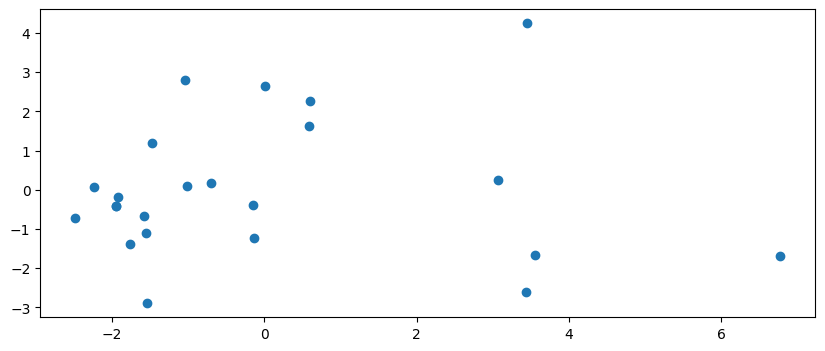

In [47]:
plt.figure(figsize=(10,4))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1])
plt.show()

Thus, we don't have to use `dtw` anymore and instead of `TimeSeriesKMeans` from `tslearn`, we can use basic `KMeans` from `sklearn`

In [48]:
kmeans = KMeans(n_clusters=k,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

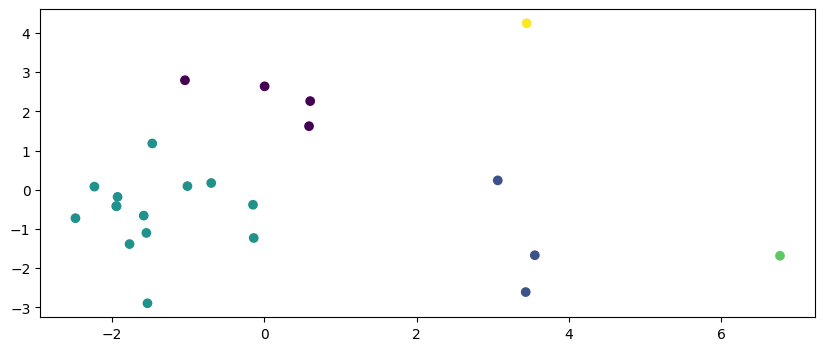

In [49]:
plt.figure(figsize=(10,4))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels)
plt.show()

And again thanks to the clever implementation of `KMeans` algorithm by `sklearn` team, labels are returned in the same order. Thus, we can use the same code to visualize our cluster in series.

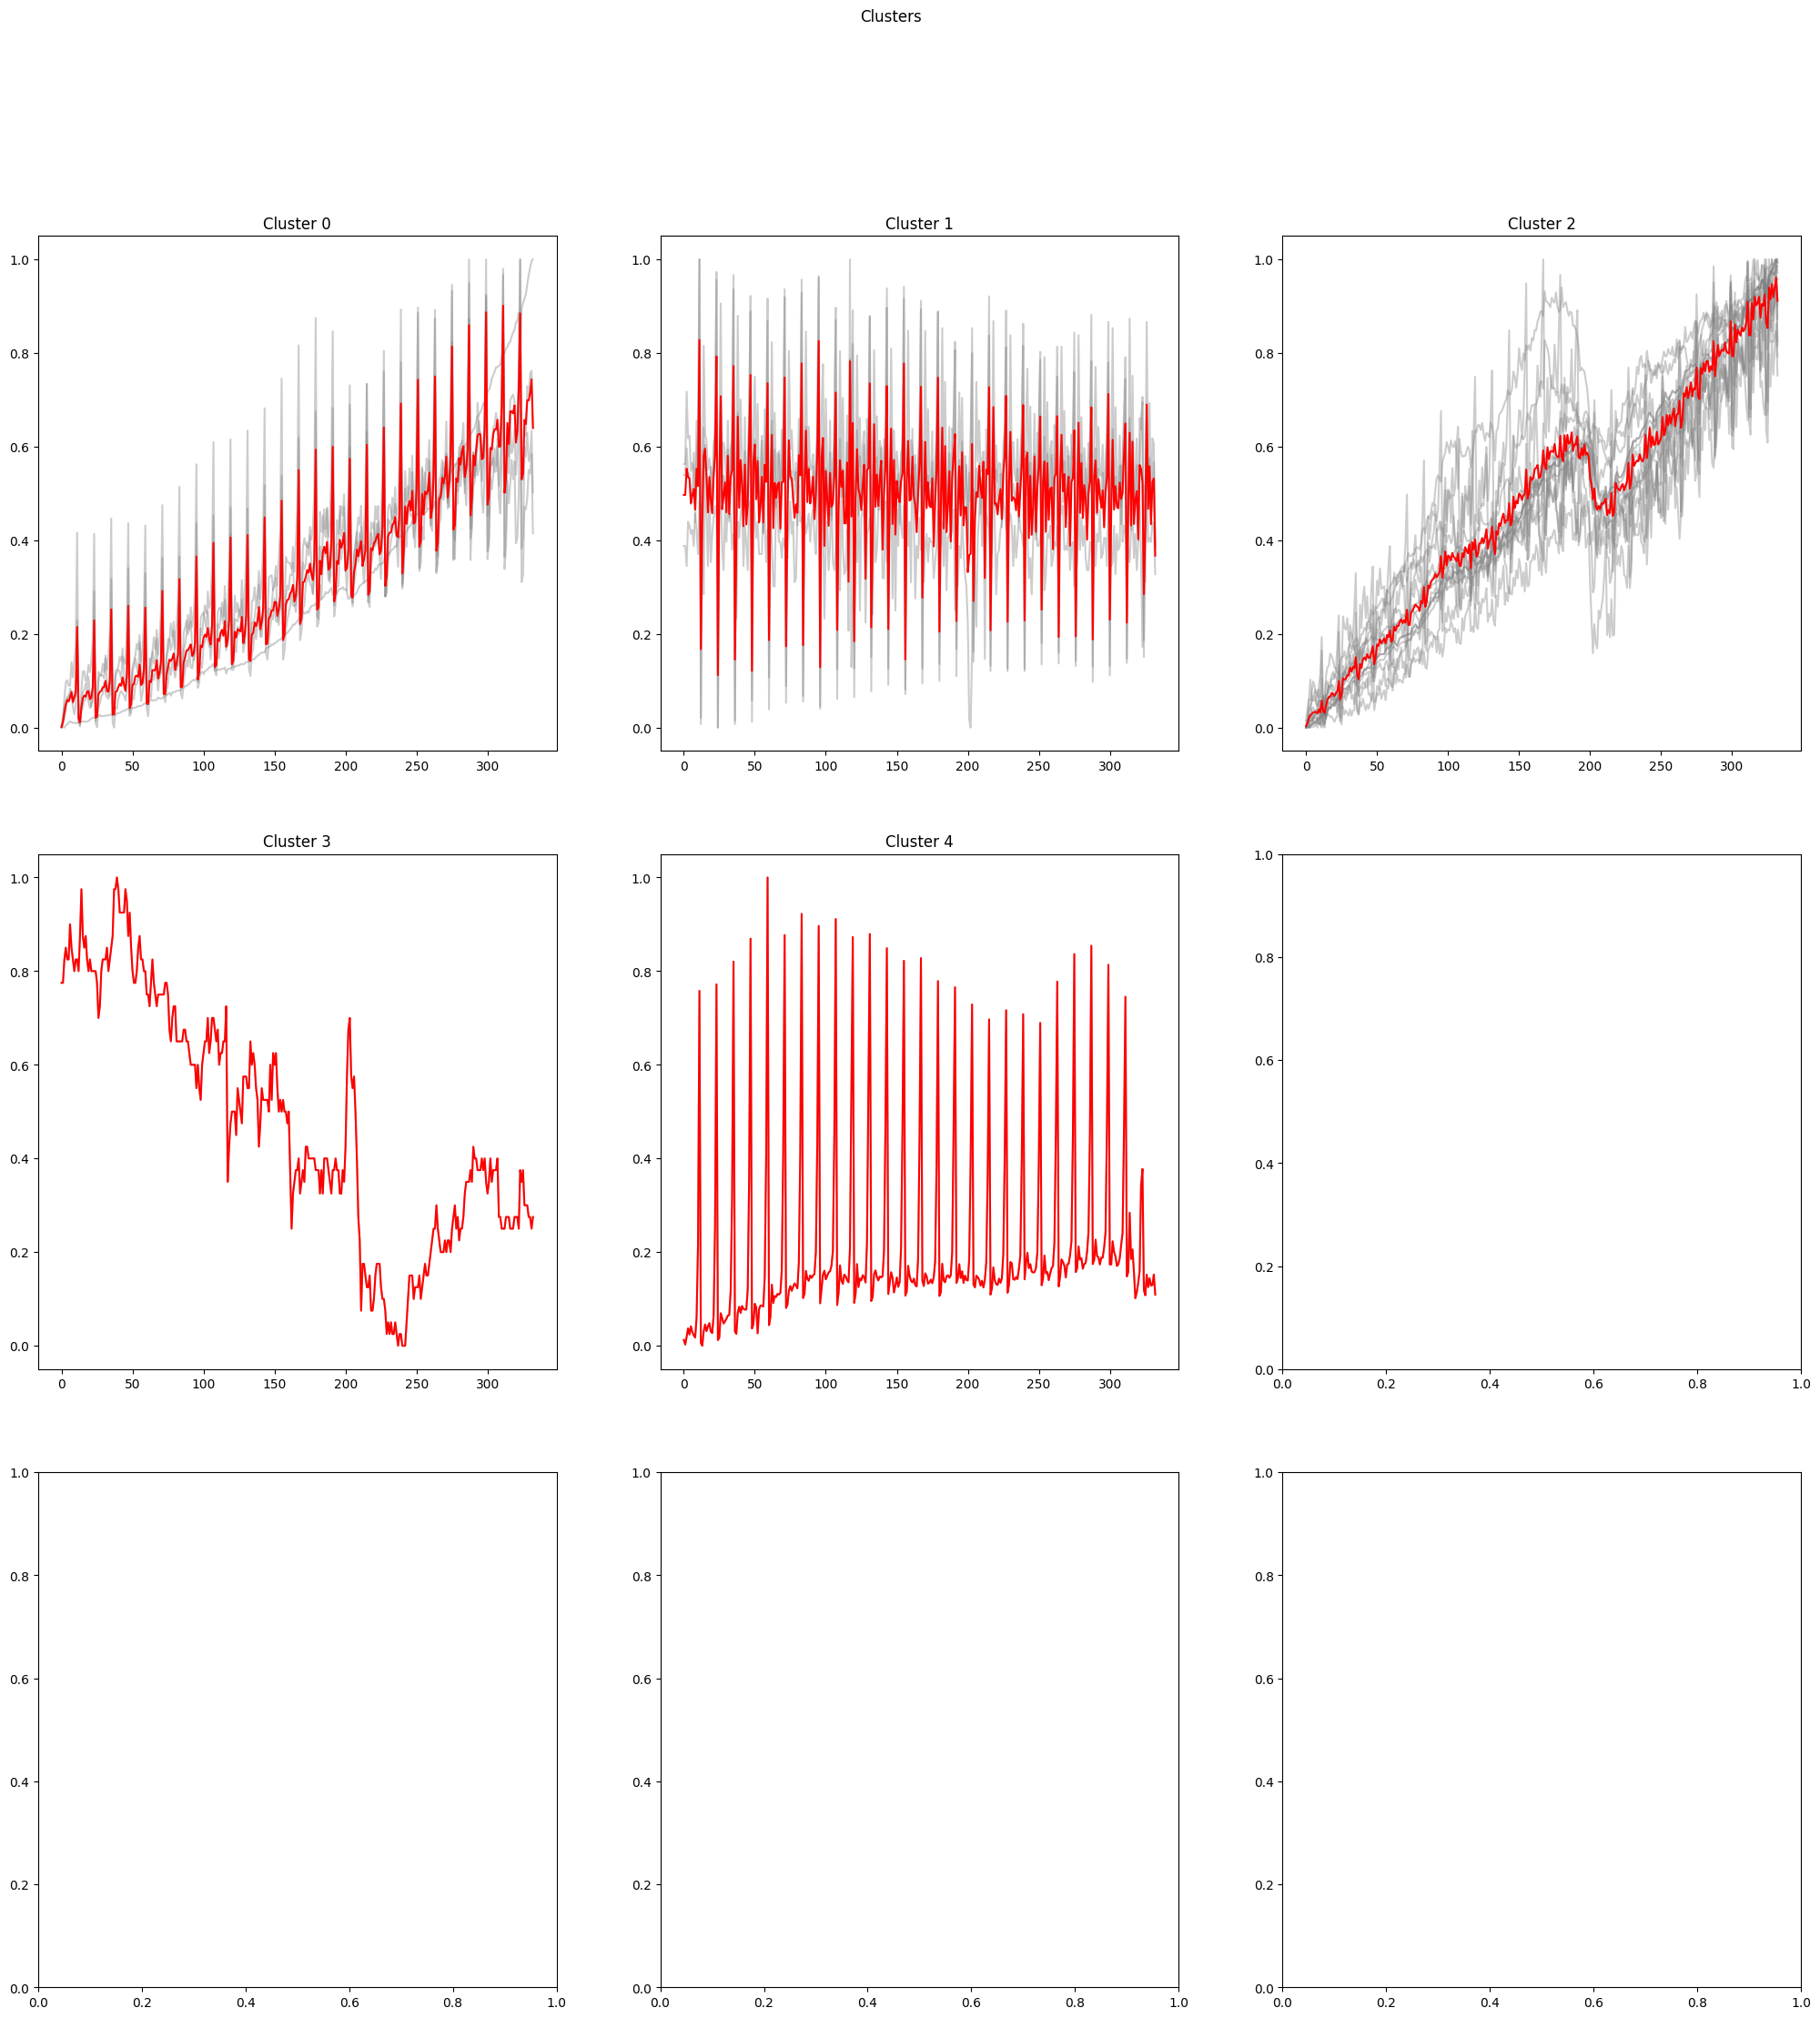

In [50]:
plot_count = math.ceil(math.sqrt(k))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

Clusters are somewhat more evenly distributed now

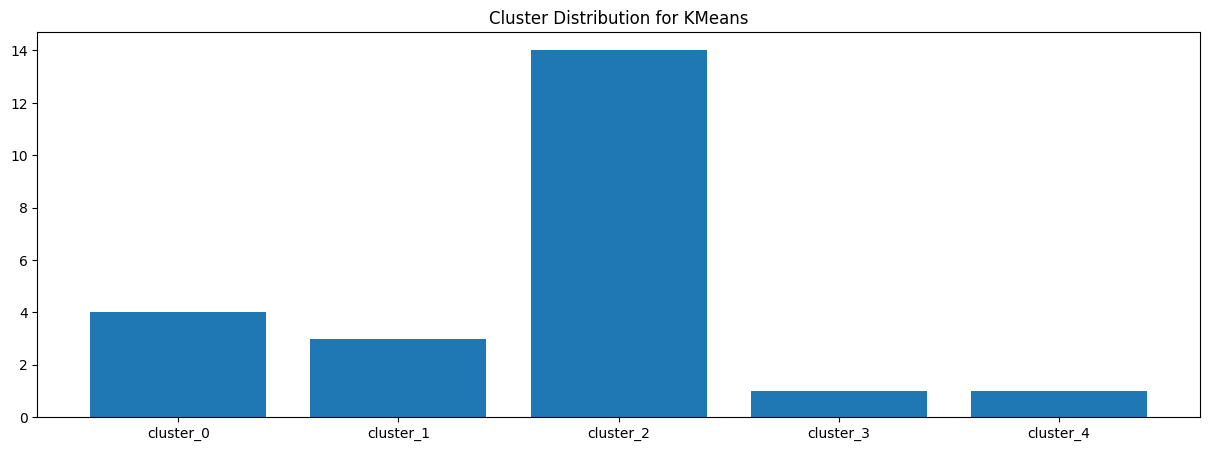

In [52]:
cluster_c = [len(labels[labels==i]) for i in range(k)]
cluster_n = ["cluster_"+str(i) for i in range(k)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()